<font size="6">__Business Case 3 - Recommender System__</font>

- Emanuele Aldera, m20210617
- Robin Schmidt, m20210602
- Muhammad Abdullah, m20210655
- Rui Ramos, m20210640

# Importing Libraries and Dataset

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_orig = pd.read_csv("retail.csv")
data_orig

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [3]:
data = data_orig.copy()

# Plot Functions

In [4]:
def pairwise_relation(data, features = data.select_dtypes(include=np.number).set_index(data.index).columns,
 title = "Pairwise Relationship of Metric Variables"):
    
    # Pairwise Relationship of Numerical Variables
    sns.set(style='white')

    # Setting pairplot
    sns.pairplot(data[features], diag_kind="hist")

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title)

    plt.show()

# Data Exploration

In [5]:
data.isna().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data_mv = data.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["Year"] = data["InvoiceDate"].dt.year
data["Month"] = data["InvoiceDate"].dt.month
data["MonthName"] = data["InvoiceDate"].dt.month_name()
data["Day"] = data["InvoiceDate"].dt.day
data["Weekday"] = data["InvoiceDate"].dt.weekday +1
data["WeekdayName"] = data["InvoiceDate"].dt.day_name()
data["IsWeekend"] = data["Weekday"] > 5
data["Time"] = data["InvoiceDate"].dt.time
data["Hour"] = data["InvoiceDate"].dt.hour

In [9]:
prods = pd.DataFrame({'hour':range(1, 25)})

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
prods['session'] = pd.cut(prods['hour'], bins=b, labels=l, include_lowest=True)

In [10]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [11]:
data["DayTime"] = data['Hour'].apply(f)

In [12]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning


In [13]:
data["StockCode"].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [14]:
data[data["StockCode"]=="85123A"].value_counts("Description")

Description
WHITE HANGING HEART T-LIGHT HOLDER    2302
CREAM HANGING HEART T-LIGHT HOLDER       9
?                                        1
wrongly marked carton 22804              1
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Year         541909 non-null  int64         
 9   Month        541909 non-null  int64         
 10  MonthName    541909 non-null  object        
 11  Day          541909 non-null  int64         
 12  Weekday      541909 non-null  int64         
 13  WeekdayName  541909 non-null  object        
 14  IsWeekend    541909 non-null  bool          
 15  Time         541909 non-null  obje

## Duplicates

In [16]:
data_dup = data.copy()
print("Percentage of suspect duplicated data: " , (data_dup.duplicated().sum() / len(data)) * 100)

Percentage of suspect duplicated data:  0.9721189350979592


In [17]:
duplicates = data_dup.loc[data_dup.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
1596,19,555524,22698,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,June,5,7,Sunday,True,11:37:00,11,Morning
1595,11,555524,22697,GREEN REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2011,6,June,5,7,Sunday,True,11:37:00,11,Morning
3171,7,572861,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-10-26 12:46:00,1.25,14102.0,United Kingdom,2011,10,October,26,3,Wednesday,False,12:46:00,12,Morning
3115,5,572344,M,Manual,48,2011-10-24 10:43:00,1.50,14607.0,United Kingdom,2011,10,October,24,1,Monday,False,10:43:00,10,Morning
470,5,540524,21756,BATH BUILDING BLOCK WORD,1,2011-01-09 12:53:00,5.95,16735.0,United Kingdom,2011,1,January,9,7,Sunday,True,12:53:00,12,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,1,556484,22429,ENAMEL MEASURING JUG CREAM,1,2011-06-12 13:17:00,4.25,16938.0,United Kingdom,2011,6,June,12,7,Sunday,True,13:17:00,13,Noon
1666,1,556484,22326,ROUND SNACK BOXES SET OF4 WOODLAND,2,2011-06-12 13:17:00,2.95,16938.0,United Kingdom,2011,6,June,12,7,Sunday,True,13:17:00,13,Noon
1665,1,556484,22139,RETROSPOT TEA SET CERAMIC 11 PC,1,2011-06-12 13:17:00,4.95,16938.0,United Kingdom,2011,6,June,12,7,Sunday,True,13:17:00,13,Noon
1664,1,556481,23182,TOILET SIGN OCCUPIED OR VACANT,3,2011-06-12 13:00:00,0.83,16115.0,United Kingdom,2011,6,June,12,7,Sunday,True,13:00:00,13,Noon


## Visual Exploration

In [18]:
numeric_features = data.select_dtypes(include=np.number).set_index(data.index).columns.tolist()
data[numeric_features]

,Quantity,UnitPrice,CustomerID,Year,Month,Day,Weekday,Hour
0,6,2.55,17850.0,2010,12,1,3,8
1,6,3.39,17850.0,2010,12,1,3,8
2,8,2.75,17850.0,2010,12,1,3,8
3,6,3.39,17850.0,2010,12,1,3,8
4,6,3.39,17850.0,2010,12,1,3,8
...,...,...,...,...,...,...,...,...
541904,12,0.85,12680.0,2011,12,9,5,12
541905,6,2.10,12680.0,2011,12,9,5,12
541906,4,4.15,12680.0,2011,12,9,5,12
541907,4,4.15,12680.0,2011,12,9,5,12


In [19]:
# def cor_heatmap(cor):
#     plt.figure(figsize=(20,20))
#     sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
#     plt.show()
    
# cor_heatmap(np.round(data.corr(method = 'spearman'),3))

In [20]:
def boxplot (data):
    from math import ceil

    metric_features = data.select_dtypes(include=np.number).set_index(data.index).columns
    sns.set()
    
    fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

    
    for ax, feat in zip(axes.flatten(), metric_features): 

        sns.boxplot(data[feat], ax = ax)
        

    
    title = "Numeric Variables' Boxplots"

    plt.suptitle(title)

    plt.show()

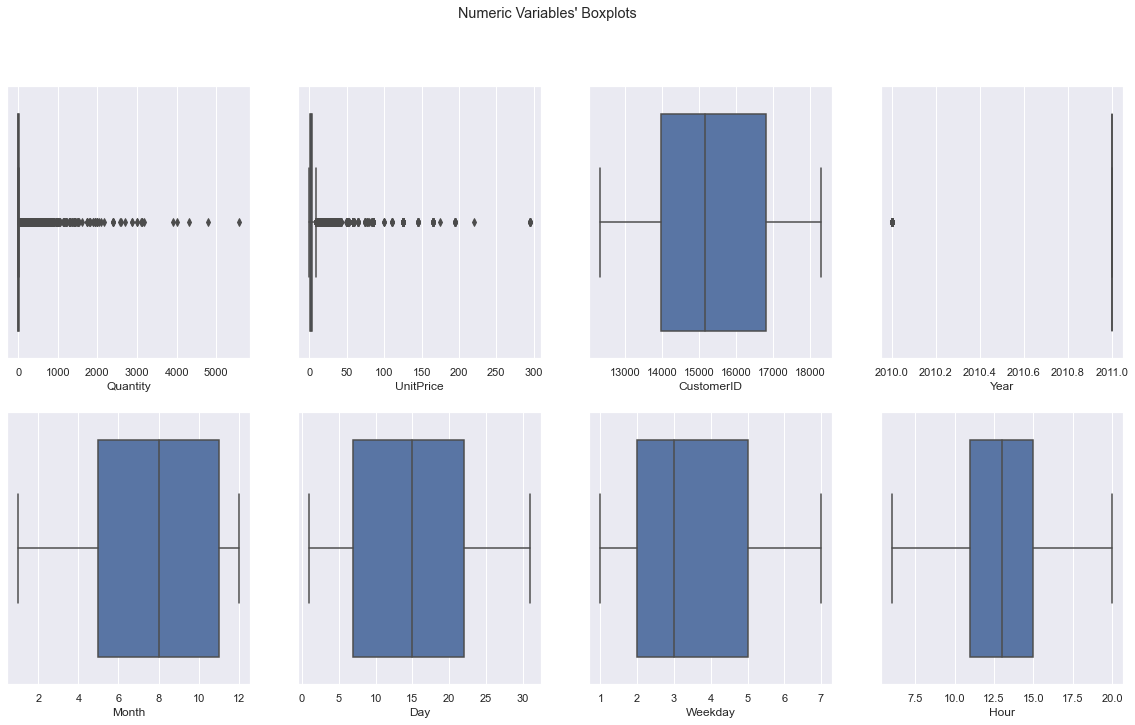

In [51]:
boxplot(data[numeric_features])

In [22]:
data[data["UnitPrice"]<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,2011,8,August,12,5,Friday,False,14:51:00,14,Noon
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,2011,8,August,12,5,Friday,False,14:52:00,14,Noon


In [23]:
data[data["Quantity"]<-60000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011,1,January,18,2,Tuesday,False,10:17:00,10,Morning
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,2011,12,December,9,5,Friday,False,09:27:00,9,Morning


In [24]:
data[data["Quantity"]>60000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011,1,January,18,2,Tuesday,False,10:01:00,10,Morning
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011,12,December,9,5,Friday,False,09:15:00,9,Morning


In [25]:
data[data["StockCode"].str.len()<5].value_counts("StockCode")

StockCode
POST    1256
DOT      710
M        571
C2       144
D         77
S         63
CRUK      16
PADS       4
B          3
m          1
dtype: int64

In [26]:
data[data["StockCode"].str.len()<5].value_counts("Description")

Description
POSTAGE                       1252
DOTCOM POSTAGE                 709
Manual                         572
CARRIAGE                       143
Discount                        77
SAMPLES                         63
CRUK Commission                 16
PADS TO MATCH ALL CUSHIONS       4
Adjust bad debt                  3
dtype: int64

In [27]:
# StockCodes with less than 5 characters to list to delete
del_stockcodes = data[data["StockCode"].str.len()<5].StockCode.unique().tolist()

In [28]:
data = data[~data["StockCode"].isin(del_stockcodes)]

In [29]:
len(data_orig) - len(data)

2845

In [30]:
data[data["Quantity"]<=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,12,December,1,3,Wednesday,False,09:49:00,9,Morning
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom,2011,12,December,9,5,Friday,False,09:57:00,9,Morning
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,2011,12,December,9,5,Friday,False,09:57:00,9,Morning
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,2011,12,December,9,5,Friday,False,11:57:00,11,Morning
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,2011,12,December,9,5,Friday,False,11:58:00,11,Morning


In [31]:
data[data["CustomerID"]==17548.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,December,1,3,Wednesday,False,10:24:00,10,Morning
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25,17548.0,United Kingdom,2011,4,April,20,3,Wednesday,False,12:01:00,12,Morning
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom,2011,4,April,20,3,Wednesday,False,12:01:00,12,Morning
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom,2011,4,April,20,3,Wednesday,False,12:01:00,12,Morning


In [32]:
data_dup = data[["StockCode","Quantity","UnitPrice","CustomerID"]]

In [33]:
data_dup["NegativeQuantity"] = data_dup["Quantity"] < 0

In [34]:
data_dup.value_counts("NegativeQuantity")

NegativeQuantity
False    528967
True      10097
dtype: int64

In [35]:
data_dup["Quantity"] = data_dup["Quantity"].abs()

In [36]:
data_pos = data_dup[data_dup["NegativeQuantity"]==False]
data_pos = data_pos.drop("NegativeQuantity",axis=1)
data_pos

,StockCode,Quantity,UnitPrice,CustomerID
0,85123A,6,2.55,17850.0
1,71053,6,3.39,17850.0
2,84406B,8,2.75,17850.0
3,84029G,6,3.39,17850.0
4,84029E,6,3.39,17850.0
...,...,...,...,...
541904,22613,12,0.85,12680.0
541905,22899,6,2.10,12680.0
541906,23254,4,4.15,12680.0
541907,23255,4,4.15,12680.0


In [37]:
data_pos[data_pos["CustomerID"] == 12472.0]

,StockCode,Quantity,UnitPrice,CustomerID
9373,22781,2,7.65,12472.0
9374,22865,24,2.10,12472.0
9375,22960,12,3.75,12472.0
9376,22961,12,1.45,12472.0
9377,22962,24,0.85,12472.0
...,...,...,...,...
446237,23571,12,1.65,12472.0
446238,23570,12,1.25,12472.0
446239,23084,48,1.79,12472.0
446240,21914,12,1.25,12472.0


In [38]:
data_neg = data_dup[data_dup["NegativeQuantity"]==True]
data_neg = data_neg.drop("NegativeQuantity",axis=1)
data_neg

,StockCode,Quantity,UnitPrice,CustomerID
154,35004C,1,4.65,15311.0
235,22556,12,1.65,17548.0
236,21984,24,0.29,17548.0
237,21983,24,0.29,17548.0
238,21980,24,0.29,17548.0
...,...,...,...,...
540448,22178,12,1.95,14397.0
540449,23144,11,0.83,14397.0
541715,21258,5,10.95,15311.0
541716,84978,1,1.25,17315.0


In [39]:
data_merge = pd.merge(data_neg, data_pos, how="inner")

In [40]:
data_merge

,StockCode,Quantity,UnitPrice,CustomerID
0,22355,2,0.85,17841.0
1,22355,2,0.85,17841.0
2,22355,2,0.85,17841.0
3,22355,2,0.85,17841.0
4,22355,2,0.85,17841.0
...,...,...,...,...
5853,23462,1,19.95,12476.0
5854,85127,5,4.95,12476.0
5855,16219,48,0.06,12985.0
5856,21642,72,0.29,12985.0


In [41]:
data[data["Quantity"]<1].isna().sum(axis = 0)

InvoiceNo         0
StockCode         0
Description     862
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1558
Country           0
Year              0
Month             0
MonthName         0
Day               0
Weekday           0
WeekdayName       0
IsWeekend         0
Time              0
Hour              0
DayTime           0
dtype: int64

In [42]:
data.groupby("CustomerID").count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime
CustomerID,,,,,,,,,,,,,,,,,
12346.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
12347.0,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182,182
12348.0,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
12349.0,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72
12350.0,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
18281.0,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
18282.0,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [50]:
data = data[data["Quantity"]>=0]
data = data[data["Quantity"]<10000]
data = data[data["UnitPrice"]<600]

In [53]:
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

In [54]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,December,1,3,Wednesday,False,08:26:00,8,Early Morning,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011,12,December,9,5,Friday,False,12:50:00,12,Morning,16.60


In [56]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,528961.0,10.355072,39.755447,1.0,1.00,3.00,11.00,5568.00
UnitPrice,528961.0,3.257511,4.205342,0.0,1.25,2.08,4.13,295.00
CustomerID,396377.0,15301.602157,1709.972762,12347.0,13975.00,15159.00,16803.00,18287.00
Year,528961.0,2010.921505,0.268950,2010.0,2011.00,2011.00,2011.00,2011.00
Month,528961.0,7.562283,3.508764,1.0,5.00,8.00,11.00,12.00
Day,528961.0,15.022769,8.662304,1.0,7.00,15.00,22.00,31.00
Weekday,528961.0,3.436490,1.850550,1.0,2.00,3.00,5.00,7.00
Hour,528961.0,13.077529,2.437735,6.0,11.00,13.00,15.00,20.00
TotalPrice,528961.0,18.880846,64.931705,0.0,3.75,9.90,17.40,7144.72


In [57]:
data["Description"].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2327
JUMBO BAG RED RETROSPOT               2115
REGENCY CAKESTAND 3 TIER              2019
PARTY BUNTING                         1707
LUNCH BAG RED RETROSPOT               1594
                                      ... 
WHITE WITH METAL BAG CHARM               1
CHRISTMAS CRAFT HEART STOCKING           1
TRAVEL CARD WALLET DOTCOMGIFTSHOP        1
GLASS CAKE COVER AND PLATE               1
POLYESTER FILLER PAD 60x40cm             1
Name: Description, Length: 4068, dtype: int64

# Recommendation Engine

## Part 1

In [63]:
popular_products = pd.DataFrame(data.groupby('StockCode')['Quantity'].sum())
most_popular = popular_products.sort_values('Quantity', ascending=False)
most_popular.head(10)

,Quantity
StockCode,
22197,56921
84077,55047
85099B,48478
85123A,41664
84879,36461
21212,36419
23084,31722
22492,26633
22616,26339


<AxesSubplot:xlabel='StockCode'>

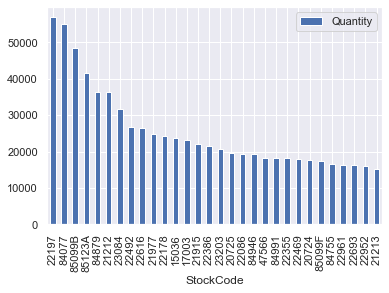

In [64]:
most_popular.head(30).plot(kind = "bar")

In [65]:
popular_products = pd.DataFrame(data.groupby('Description')['Quantity'].sum())
most_popular = popular_products.sort_values('Quantity', ascending=False)
most_popular.head(10)

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047
JUMBO BAG RED RETROSPOT,48478
WHITE HANGING HEART T-LIGHT HOLDER,37895
POPCORN HOLDER,36761
ASSORTED COLOUR BIRD ORNAMENT,36461
PACK OF 72 RETROSPOT CAKE CASES,36419
RABBIT NIGHT LIGHT,30788
MINI PAINT SET VINTAGE,26633
PACK OF 12 LONDON TISSUES,26339


<AxesSubplot:xlabel='Description'>

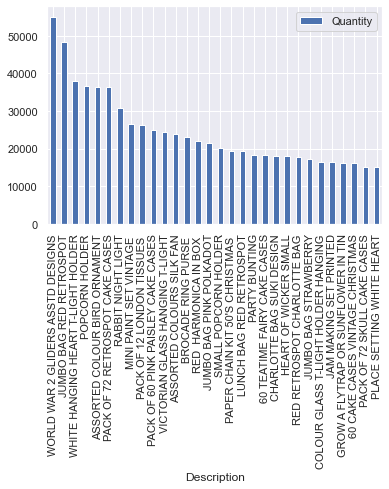

In [66]:
most_popular.head(30).plot(kind = "bar")

In [62]:
data[data["StockCode"]=="22197"].value_counts("Description")

Description
POPCORN HOLDER          829
SMALL POPCORN HOLDER    597
dtype: int64

## Part 2

In [70]:
data1 = data.head(10000)

In [72]:
price_utility_matrix = data1.pivot_table(values='TotalPrice', index=data1.index, columns='StockCode', fill_value=0)
price_utility_matrix.head()

StockCode,10002,10120,10123C,10124G,10125,10133,10135,11001,15034,15036,...,90214I,90214J,90214L,90214M,90214N,90214R,90214S,90214V,90214Y,BANK CHARGES
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [74]:
price_utility_matrix.shape

(10000, 2011)

In [76]:
X = price_utility_matrix.T
X.head()

,0,1,2,3,4,5,6,7,8,9,...,10156,10157,10158,10159,10160,10161,10162,10163,10164,10165
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10123C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10124G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
X1 = X

In [80]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2011, 10)

In [81]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(2011, 2011)

In [82]:
X.index[99]

'20719'

In [83]:
i = "20719"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

In [84]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(2011,)

In [85]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['10120',
 '10135',
 '15056BL',
 '15056P',
 '15060B',
 '16218',
 '16225',
 '16238',
 '17012A']

In [86]:
data[data["StockCode"]=="20719"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice
1867,536544,20719,WOODLAND CHARLOTTE BAG,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,2010,12,December,1,3,Wednesday,False,14:32:00,14,Noon,3.32
4456,536783,20719,WOODLAND CHARLOTTE BAG,100,2010-12-02 15:19:00,0.72,15061.0,United Kingdom,2010,12,December,2,4,Thursday,False,15:19:00,15,Noon,72.00
4499,536784,20719,WOODLAND CHARLOTTE BAG,30,2010-12-02 15:20:00,0.72,15061.0,United Kingdom,2010,12,December,2,4,Thursday,False,15:20:00,15,Noon,21.60
4615,536796,20719,WOODLAND CHARLOTTE BAG,1,2010-12-02 15:46:00,0.85,15574.0,United Kingdom,2010,12,December,2,4,Thursday,False,15:46:00,15,Noon,0.85
4672,536796,20719,WOODLAND CHARLOTTE BAG,1,2010-12-02 15:46:00,0.85,15574.0,United Kingdom,2010,12,December,2,4,Thursday,False,15:46:00,15,Noon,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538178,581401,20719,WOODLAND CHARLOTTE BAG,10,2011-12-08 13:43:00,0.85,17644.0,United Kingdom,2011,12,December,8,4,Thursday,False,13:43:00,13,Noon,8.50
538876,581420,20719,WOODLAND CHARLOTTE BAG,10,2011-12-08 15:09:00,0.85,16358.0,United Kingdom,2011,12,December,8,4,Thursday,False,15:09:00,15,Noon,8.50
539383,581439,20719,WOODLAND CHARLOTTE BAG,3,2011-12-08 16:30:00,1.63,NaN,United Kingdom,2011,12,December,8,4,Thursday,False,16:30:00,16,Noon,4.89
540760,581492,20719,WOODLAND CHARLOTTE BAG,7,2011-12-09 10:03:00,1.63,NaN,United Kingdom,2011,12,December,9,5,Friday,False,10:03:00,10,Morning,11.41


In [88]:
data[data["StockCode"]=="10135"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,MonthName,Day,Weekday,WeekdayName,IsWeekend,Time,Hour,DayTime,TotalPrice
2461,536592,10135,COLOURING PENCILS BROWN TUBE,1,2010-12-01 17:06:00,2.51,NaN,United Kingdom,2010,12,December,1,3,Wednesday,False,17:06:00,17,Eve,2.51
3330,536621,10135,COLOURING PENCILS BROWN TUBE,10,2010-12-02 10:35:00,1.25,13108.0,United Kingdom,2010,12,December,2,4,Thursday,False,10:35:00,10,Morning,12.50
6168,536876,10135,COLOURING PENCILS BROWN TUBE,1,2010-12-03 11:36:00,2.51,NaN,United Kingdom,2010,12,December,3,5,Friday,False,11:36:00,11,Morning,2.51
8088,537126,10135,COLOURING PENCILS BROWN TUBE,1,2010-12-05 12:13:00,1.25,18118.0,United Kingdom,2010,12,December,5,7,Sunday,True,12:13:00,12,Morning,1.25
8195,537129,10135,COLOURING PENCILS BROWN TUBE,10,2010-12-05 12:15:00,1.25,13506.0,United Kingdom,2010,12,December,5,7,Sunday,True,12:15:00,12,Morning,12.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518026,580107,10135,COLOURING PENCILS BROWN TUBE,10,2011-12-01 15:32:00,1.25,15948.0,United Kingdom,2011,12,December,1,4,Thursday,False,15:32:00,15,Noon,12.50
524604,580606,10135,COLOURING PENCILS BROWN TUBE,20,2011-12-05 11:38:00,1.25,15290.0,United Kingdom,2011,12,December,5,1,Monday,False,11:38:00,11,Morning,25.00
528083,580727,10135,COLOURING PENCILS BROWN TUBE,8,2011-12-05 17:17:00,2.46,14096.0,United Kingdom,2011,12,December,5,1,Monday,False,17:17:00,17,Eve,19.68
534232,581141,10135,COLOURING PENCILS BROWN TUBE,10,2011-12-07 13:35:00,1.25,14132.0,United Kingdom,2011,12,December,7,3,Wednesday,False,13:35:00,13,Noon,12.50


## Part 3

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [94]:
product_descriptions = data[["StockCode","Description"]].dropna()
product_descriptions

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
541904,22613,PACK OF 20 SPACEBOY NAPKINS
541905,22899,CHILDREN'S APRON DOLLY GIRL
541906,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE


In [126]:
product_descriptions1 = product_descriptions.head(10000)
# product_descriptions1.iloc[:,1]

product_descriptions1["Description"].head(10)

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
5           SET 7 BABUSHKA NESTING BOXES
6      GLASS STAR FROSTED T-LIGHT HOLDER
7                 HAND WARMER UNION JACK
8              HAND WARMER RED POLKA DOT
9          ASSORTED COLOUR BIRD ORNAMENT
Name: Description, dtype: object

In [127]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["Description"])
X1

<10000x1434 sparse matrix of type '<class 'numpy.float64'>'
	with 40723 stored elements in Compressed Sparse Row format>

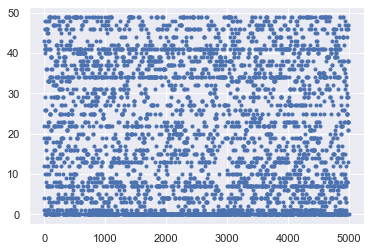

In [116]:
# # Fitting K-Means to the dataset

# X=X1

# kmeans = KMeans(n_clusters = 50, init = 'k-means++')
# y_kmeans = kmeans.fit_predict(X)
# plt.plot(y_kmeans, ".")
# plt.show()

In [110]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [133]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 water
 hot
 bottle
 grey
 knitted
 sympathy
 flag
 scottie
 heart
 charlie
Cluster 1:
 hand
 warmer
 design
 owl
 jack
 scotty
 union
 dog
 bird
 red
Cluster 2:
 alarm
 bakelike
 clock
 green
 red
 ivory
 orange
 pink
 chocolate
 travel
Cluster 3:
 heart
 light
 holder
 white
 hanging
 large
 glass
 finish
 red
 frame
Cluster 4:
 bag
 jumbo
 lunch
 retrospot
 charlotte
 red
 design
 suki
 shoulder
 pink
Cluster 5:
 metal
 sign
 lantern
 french
 bathroom
 person
 white
 decoration
 chocolate
 zinc
Cluster 6:
 box
 lunch
 recipe
 trinket
 harmonica
 rose
 victorian
 sewing
 tissue
 blue
Cluster 7:
 christmas
 chain
 tree
 kit
 paper
 vintage
 decoration
 star
 wooden
 heart
Cluster 8:
 small
 12
 tube
 tissues
 pencils
 pack
 heart
 wicker
 popcorn
 red
Cluster 9:
 set
 red
 retrospot
 cake
 pink
 mug
 vintage
 blue
 feltcraft
 polkadot


In [124]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [134]:
show_recommendations("easter")

Cluster 9:
 set
 red
 retrospot
 cake
 pink
 mug
 vintage
 blue
 feltcraft
 polkadot


In [135]:
show_recommendations("car")

Cluster 9:
 set
 red
 retrospot
 cake
 pink
 mug
 vintage
 blue
 feltcraft
 polkadot


In [136]:
show_recommendations("knife")

Cluster 9:
 set
 red
 retrospot
 cake
 pink
 mug
 vintage
 blue
 feltcraft
 polkadot


In [138]:
show_recommendations("popcorn")

Cluster 9:
 set
 red
 retrospot
 cake
 pink
 mug
 vintage
 blue
 feltcraft
 polkadot
